### Critical windows with the causal RF: Analysis Phase 3 ("most realistic")
- The objective of this analysis phase it to perform tests which incorporate correlation between exposure over time. The causal RF may have greater difficulty recovering the effect of correlated exposures.  
- All models use a random draw of 5000 exposure profiles from the cohort's actual exposure profiles, with an outcome based on actual birth weight mean and df. One exposure is confounding the critical exposure(s).   

**Model 3.A:** a naive critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

**Model 3.B:** a time-varying critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

**Model 3.C:** a concentrated critical exposure  
- 6 exposures: 1 critical, 4 not critical, 1 confounder on critical exposure  
- the exposure effect is concentrated (e.g., in week 3); i.e., the full effect of CW in model 1.C is concentrated in a single exposure  

In [25]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import binom
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import SparseLinearDML
from econml.dml import CausalForestDML
from sklearn.preprocessing import PolynomialFeatures

np.set_printoptions(suppress=True)

In [3]:
np.random.seed(1004) # use throughout

Cohort information
Get the mean and SD for ozone exposure and birth weight.

In [4]:
births = pd.read_csv("data/birth_w_sga_confounders.csv")# "data/birth_w_percentile_confounders.csv")
births.head()

o3_mean = births[['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                  'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                  'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                  'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                  'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20']].values.mean() #births_long['max_o3'].mean()
o3_sd = births[['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20']].values.std() #average_selected_columns = df[['col2', 'col3']].mean() #births_long['max_o3'].std()

bwp_mean = 100*births["bw_percentile"].mean()
bwp_sd = 100*births["bw_percentile"].std()

sga_prop = births['sga'].value_counts('sga')[1]

/var/folders/75/b6cym0892z93rs6dbfy789240000gn/T/ipykernel_1020/3798671032.py:1: DtypeWarning: Columns (15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  births = pd.read_csv("data/birth_w_sga_confounders.csv")# "data/birth_w_percentile_confounders.csv")
/var/folders/75/b6cym0892z93rs6dbfy789240000gn/T/ipykernel_1020/3798671032.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sga_prop = births['sga'].value_counts('sga')[1]


##### "Data"
A few conventions: `T` is treatments, `W` is confounders (aka controls), and `X` is features (includes confounders and covariates, but not treatment). For all models in this project, `X = W`, as there are no covariates, only confounders.

In [5]:
n_samples = 5000 # 5000

n_X = 1
n_T = 20 # one critical, two not
n_W = 1 # one confounder

# treatments / exposures; 10 ppb scale
# T_sample = births.sample(n = n_samples, replace = False)
births_sga_split = [y for x, y in births.groupby('sga')]
births_sga_split[0] # not sga
births_sga_split[1] # sga
T_sample = pd.concat([births_sga_split[0].sample(n = 3000, replace = False),
                 births_sga_split[1].sample(n = 2000, replace = False)])

T_01 = (T_sample['max_o3_01'] - o3_mean) / 10
T_03 = (T_sample['max_o3_03'] - o3_mean) / 10
T_02 = (T_sample['max_o3_02'] - o3_mean) / 10
T_04 = (T_sample['max_o3_04'] - o3_mean) / 10
T_05 = (T_sample['max_o3_05'] - o3_mean) / 10
T_06 = (T_sample['max_o3_06'] - o3_mean) / 10
T_07 = (T_sample['max_o3_07'] - o3_mean) / 10
T_08 = (T_sample['max_o3_08'] - o3_mean) / 10
T_09 = (T_sample['max_o3_09'] - o3_mean) / 10
T_10 = (T_sample['max_o3_10'] - o3_mean) / 10
T_11 = (T_sample['max_o3_11'] - o3_mean) / 10
T_12 = (T_sample['max_o3_12'] - o3_mean) / 10
T_13 = (T_sample['max_o3_13'] - o3_mean) / 10
T_14 = (T_sample['max_o3_14'] - o3_mean) / 10
T_15 = (T_sample['max_o3_15'] - o3_mean) / 10
T_16 = (T_sample['max_o3_16'] - o3_mean) / 10
T_17 = (T_sample['max_o3_17'] - o3_mean) / 10
T_18 = (T_sample['max_o3_18'] - o3_mean) / 10
T_19 = (T_sample['max_o3_19'] - o3_mean) / 10
T_20 = (T_sample['max_o3_20'] - o3_mean) / 10


Look at correlation

In [6]:
T_vars = np.vstack((T_01, T_02, T_03, T_04, T_05,
                    T_06, T_07, T_08, T_09, T_10,
                    T_11, T_12, T_13, T_14, T_15,
                    T_16, T_17, T_18, T_19, T_20))
# correlation_matrix = np.corrcoef(T_vars)
# print(correlation_matrix_np)

# correlation_matrix = T_vars.corr(numeric_only=True)

# plt.figure(figsize=(8, 6)) # Adjust figure size as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5,
#             annot_kws={"size": 7})
# plt.title('Correlation Matrix Heatmap')
# plt.show()


Adjust the confounder so it is related to one treatment.

In [7]:
np.random.seed(1004)

## Confounder coefficient
b_W0T9 = 2.5
b_W0T10 = 2.5
b_W0T11 = 2.5
X = b_W0T9 * T_09 + b_W0T10 * T_10 + b_W0T11 * T_11 + np.random.normal(size=n_samples)
# z scale
X = X / X.std()
X = X.to_numpy()

# a 2.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

In [8]:
## calculating hull for pdp 
# don't worry about this in simulations
# will be useful in application

# cond_10 = T["critical_tx_10"] <= -1
# cond_9 = T["critical_tx_9"] <= -2
# combined_condition = cond_9 & cond_10

# print(len(T[combined_condition]))


# for i in [-2, -1, 0, 1, 2]:
#     for j in [-2, -1, 0, 1, 2]:
#         print("10 = " + str(i) + ", 9 =" + str(j))


#         cond_10 = T["critical_tx_10"] <= i
#         cond_9 = T["critical_tx_9"] <= j
#         combined_condition = cond_9 & cond_10

#         print(len(T[combined_condition]))

In [9]:
# plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # one example of unconfounded, noncritical tx
# plt.plot(X, T_8, 'o', alpha = 0.2, color = "darkblue") # one example of unconfounded, noncritical tx
# plt.plot(X, T_9, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
# plt.plot(X, T_10, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
# plt.plot(X, T_11, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
# plt.xlabel("Confounder")
# plt.ylabel("Treatments (z-scaled O3)")
# plt.show()

Create the critical window coefficients

In [58]:
study_period = np.linspace(1, 20, 20)
effect_size = math.log(1.3) # 3% greater risk of SGA: https://www.sciencedirect.com/science/article/pii/S0160412022004810#s0080
# the window should be 9 wide, then 7 wide, then 3 wide
window_start = 6
window_center = 10
window_end = 14

uni_pdf = stats.Uniform(a = window_start, b = window_end)
uni_wide_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 1, b = window_end - 1)
uni_moderate_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 3, b = window_end - 3)
uni_narrow_fx  = uni_pdf.pdf(study_period) * effect_size

norm_pdf = stats.norm.pdf(study_period, window_center, 2.5)
norm_wide_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 1)
norm_moderate_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 0.5)
norm_narrow_fx = norm_pdf * effect_size 

In [59]:
# get a list of treatment variables, to assign to coefficients
week_list = list(map(str, np.arange(1, 21)))
week_list = [str(num).zfill(2) for num in week_list]

T_vars_names = list(map(lambda item: "T_" + item, week_list))

Create the outcome using PDFs

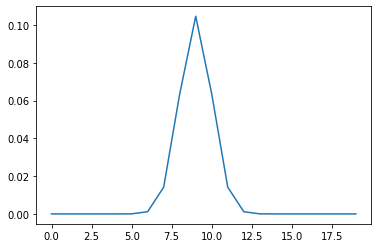

In [60]:
plt.plot(norm_moderate_fx)
# math.log(1.3)

0.6368

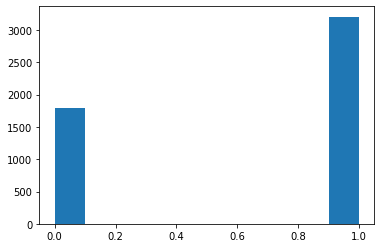

In [61]:
# the coefficients and treatment variables
tx_fx, tx = norm_moderate_fx, T_vars
# the vectors of each coefficient * treatment variable
tx_fx_list = [tx[i] * tx_fx[i] for i in np.arange(0, 20)] #0, 20 # when testing interaction: (8, 10)
# total treatment effect by individual
total_tx_fx = [sum(fx) for fx in zip(*tx_fx_list)]

# other things to add to linear predictor
beta0 = 0.4 # odds when all predictors = 0
beta_X = 0.15 # confounder
e = np.random.normal(size=n_samples, loc = 0, scale = 0.02)

linear_predictor = [(beta0 + fx + beta_X) for fx in total_tx_fx]# + e

probabilities = [(1 / (1 + math.exp(-x))) for x in linear_predictor]
probabilities
# plt.hist(probabilities)

n_trials = 10
num_samples = 5
y = binom.rvs(1, probabilities, size=5000)
plt.hist(random_samples)

# 60-40 in the sample
T_sample['sga'].value_counts("sga")
# about 60-40 in the outcome
np.mean(y)

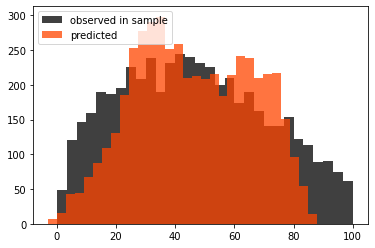

bw mean: 45.95544763593132
y-hat mean 46.226825462512664
bw sd: 24.946087669056993
y-hat sd 19.677540937441975


In [42]:
# # the coefficients and treatment variables
# tx_fx, tx = norm_moderate_fx, T_vars
# # the vectors of each coefficient * treatment variable
# tx_fx_list = [tx[i] * tx_fx[i] for i in np.arange(0, 20)] #0, 20 # when testing interactoin: (8, 10)
# # total treatment effect by individual
# total_tx_fx = [sum(fx) for fx in zip(*tx_fx_list)]

# # the confounder effect (z-scaled, see above)
# b_W0y = -2.5
# # the vector of confounder effects
# wx_fx = X * b_W0y

# # bit of noise
# # 1:5 signal:noise; 15:75; sqrt(75) ~ 8.66
# ##### deprecated: 1:5 signal:noise; 166:830; sqrt(830) ~ 29
# e = np.random.normal(size=n_samples, loc = 0, scale = 1)

# # intercept
# b_int = bwp_mean

# # interaction effect
# # b_intx = -200
# # intx_fx = b_intx * tx[8] * tx[9] #[b_intx * tx[i] for i in np.arange(8, 10)]

# y = b_int + total_tx_fx + wx_fx + e# + intx_fx


# plt.hist(T_sample["bw_percentile"]*100, bins = 30,
#          alpha = 0.75,# edgecolor = "white", 
#          color = "black",
#          label = "observed in sample")
# plt.hist(y, bins = 30, alpha = 0.75,
#          #edgecolor = "white",
#          color = "orangered", 
#          label = "predicted")
# plt.legend(loc = 'upper left')
# plt.show()

# print("bw mean:", bwp_mean)
# print("y-hat mean", sum(y) / len(y))
# print("bw sd:", bwp_sd)
# print("y-hat sd", np.std(y))

In [43]:
# T_sample["bw_percentile"].describe()

count    5000.000000
mean        0.462880
std         0.245862
min         0.000151
25%         0.263428
50%         0.448996
75%         0.647848
max         1.000000
Name: bw_percentile, dtype: float64

Correlation between exposures, outcome

In [44]:
# plt.plot(T_8, y, 'o', alpha = 0.2, color = "black") # noncritical tx in black
# plt.plot(T_15, y, 'o', alpha = 0.2, color = "darkblue") # noncritical tx in black
# plt.plot(T_9, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
# plt.plot(T_10, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
# plt.plot(T_11, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
# plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in violet
# plt.xlabel("Treatments (z-scaled O3)")
# plt.ylabel("Birth weight (grams)")
# plt.show()

Matrices for treatments, confounders

In [95]:
sex_encoded = pd.get_dummies(T_sample, columns=['gender'], drop_first=True) # drop_first avoids multicollinearity
race_encoded = pd.get_dummies(T_sample, columns=['race_ethn']) # drop_first avoids multicollinearity

In [97]:
# T_sample.head()
sex_encoded['gender_Male'],
race_encoded['race_ethn_amindian'],
race_encoded['race_ethn_asian'],
race_encoded['race_ethn_black'],
race_encoded['race_ethn_hispanic'],
race_encoded['race_ethn_nhopi'],
race_encoded['race_ethn_other']

,gestation,gender,momid,birthdd,birthmm,birthccyy,race,ethn,hypertension_pre,hypertension_gest,...,X,bw_zscore,bw_percentile,race_ethn_amindian,race_ethn_asian,race_ethn_black,race_ethn_hispanic,race_ethn_nhopi,race_ethn_other,race_ethn_white
34849,40,Male,513950155.0,21,2,2015,asian,not hispanic,0,0,...,NaN,-0.663286,0.253574,False,True,False,False,False,False,False
29615,40,Female,528734805.0,16,2,2014,white,not hispanic,0,0,...,NaN,-1.146237,0.125849,False,False,False,False,False,False,True
37493,40,Male,618489812.0,12,9,2016,white,not hispanic,0,0,...,NaN,-0.484787,0.313914,False,False,False,False,False,False,True
25405,39,Male,641305678.0,20,4,2015,white,not hispanic,0,0,...,NaN,-2.124498,0.016814,False,False,False,False,False,False,True
14819,39,Female,502218126.0,4,3,2015,white,not hispanic,0,0,...,NaN,-1.423313,0.077323,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,37,Female,646230963.0,26,7,2016,white,not hispanic,0,0,...,NaN,0.065336,0.526047,False,False,False,False,False,False,True
29706,40,Female,528844067.0,31,12,2016,white,not hispanic,0,0,...,NaN,-1.200000,0.115070,False,False,False,False,False,False,True
8512,38,Female,590283416.0,19,12,2014,white,not hispanic,0,0,...,NaN,0.421875,0.663442,False,False,False,False,False,False,True
39068,40,Male,647074649.0,17,8,2016,white,not hispanic,0,0,...,NaN,-1.139959,0.127152,False,False,False,False,False,False,True


In [62]:
T = pd.DataFrame({'noncritical_tx_01': T_01, 'noncritical_tx_02': T_02, 
                  'noncritical_tx_03': T_03, 'noncritical_tx_04': T_04, 
                  'noncritical_tx_05': T_05, 'noncritical_tx_06': T_06, 
                  'noncritical_tx_07': T_07, 'critical_tx_08': T_08, 
                  'critical_tx_09': T_09, 'critical_tx_10': T_10,
                  'critical_tx_11': T_11, 'critical_tx_12': T_12, 
                  'noncritical_tx_13': T_13, 'noncritical_tx_14': T_14, 
                  'noncritical_tx_15': T_15, 'noncritical_tx_16': T_16, 
                  'noncritical_tx_17': T_17, 'noncritical_tx_18': T_18, 
                  'noncritical_tx_19': T_19, 'noncritical_tx_20': T_20#,
                #    'gestational_age': T_sample["gestation"],
                #    'gender_Male': sex_encoded['gender_Male']
                   #'weeks9_and_10': tx[8] * tx[9]
                  })
X = pd.DataFrame(X, columns=['confounder'])
# X = pd.DataFrame({'max_temp_11': T_sample['max_temp_11'],
#                   'max_temp_12': T_sample['max_temp_12'],
#                   'max_pm_11': T_sample['max_pm_11'],
#                   'max_pm_12': T_sample['max_pm_12'],
#                   'race_ethn_amindian': race_encoded['race_ethn_amindian'],
#                   'race_ethn_asian': race_encoded['race_ethn_asian'],
#                   'race_ethn_black': race_encoded['race_ethn_black'],
#                   'race_ethn_hispanic': race_encoded['race_ethn_hispanic'],
#                   'race_ethn_nhopi': race_encoded['race_ethn_nhopi'],
#                   'race_ethn_other': race_encoded['race_ethn_other']})
y = pd.DataFrame({'sga': y})
# y = T_sample["birthweightgrams"]

##### Causal RF  

In [29]:
# featurizer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False, order = 'F')

# X_interactions = featurizer.fit_transform(T)

# test = SparseLinearDML(model_t='forest',
#                        model_y='forest',
#                        discrete_treatment=False,# treatment_featurizer=featurizer,
#                        #n_estimators=500,# 
#                        n_jobs = 4)

# test.fit(y, T = X, X = X, W = X)
# test.marginal_ate_inference(T, X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:75: UserWarning: The number of features in the final model (< 5) is too small for a sparse model. We recommend using the LinearDML estimator for this low-dimensional setting.
  warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ba

In [63]:
# featurizer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False, order = 'F')

# X_interactions = featurizer.fit_transform(T)

est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      discrete_outcome=True,
                      #n_estimators=500, treatment_featurizer=featurizer,
                      n_jobs = 4)

est.fit(y, T=T, X=X, W=X)
# takes 20-40 seconds w/ 5000

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Extract the marginal effects

In [64]:
# takes 20-30 seconds

# est.marginal_effect_inference(T, X)
# test = est.marginal_effect_inference(T, X)
# test.population_summary()
# (T, X)
## -40.3 vs -40.1
## -65.2 vs. -66.2

est.marginal_ate_inference(T, X)

,mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
T0,-0.005,0.185,-0.027,0.978,-0.368,0.358
T1,-0.018,0.207,-0.087,0.931,-0.423,0.387
T2,-0.018,0.189,-0.098,0.922,-0.389,0.352
T3,-0.005,0.195,-0.026,0.979,-0.387,0.376
T4,-0.0,0.208,-0.001,1.0,-0.408,0.408
T5,0.021,0.2,0.103,0.918,-0.371,0.412
T6,0.005,0.199,0.024,0.98,-0.386,0.396
T7,0.016,0.227,0.072,0.943,-0.429,0.462
T8,0.035,0.284,0.122,0.903,-0.522,0.592
T9,0.009,0.29,0.031,0.975,-0.559,0.577


In [112]:
print(est.cate_treatment_names()) # all interact with all
est.const_marginal_ate_inference(X)

['critical_tx_11', 'critical_tx_12', 'gestational_age', 'gender_Male']


In [54]:
T.head()
means

array([[ 0.0142164 , -0.0348274 , -0.00987624, -0.01047108,  0.02011471,
        -0.00183217,  0.03758409, -0.02407829, -0.05017132, -0.04542453,
        -0.03606176,  0.00192509,  0.01211611, -0.00124252,  0.01664755,
        -0.02799511,  0.01262755, -0.00052414, -0.0194947 ,  0.01369641]])

In [65]:
# Extract all values once
treatments = np.array(est.cate_treatment_names())
means = np.array(est.marginal_ate(T, X))
ci_lower, ci_upper = est.marginal_ate_interval(T, X)

# Construct DataFrame directly
res_df = pd.DataFrame({
    'treatment': treatments,
    'mean': means[0],
    'ci_lower': ci_lower[0],
    'ci_upper': ci_upper[0]
})

res_df

,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_01,-0.005079,-0.368327,0.358169
1,noncritical_tx_02,-0.017883,-0.422622,0.386856
2,noncritical_tx_03,-0.018491,-0.388812,0.351830
3,noncritical_tx_04,-0.005077,-0.386573,0.376420
4,noncritical_tx_05,-0.000130,-0.407872,0.407612
5,noncritical_tx_06,0.020671,-0.370952,0.412293
6,noncritical_tx_07,0.004885,-0.386049,0.395818
7,critical_tx_08,0.016379,-0.429386,0.462144
8,critical_tx_09,0.034677,-0.522310,0.591664
9,critical_tx_10,0.009111,-0.558669,0.576892


Plot the marginal effects

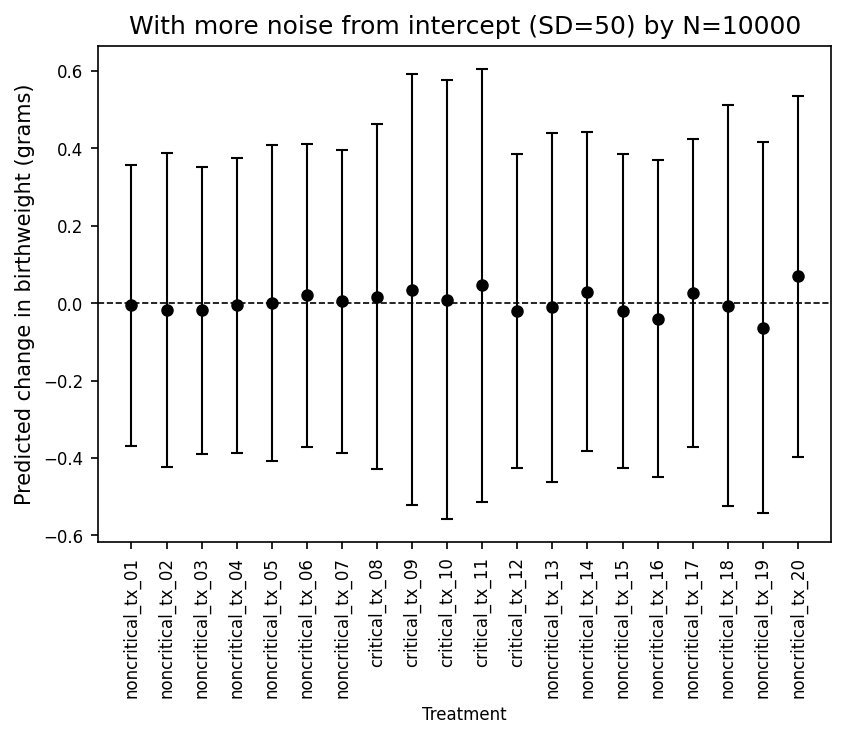

In [66]:
plt.figure(figsize=(6, 4), dpi=150)
# ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
ci = np.array([res_df['mean'] - res_df['ci_lower'], res_df['ci_upper'] - res_df['mean']])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
plt.xticks(rotation=90)
plt.title("With more noise from intercept (SD=50) by N=10000")
# plt.savefig('raw_forest_plot.png')
plt.show()

Trying to recover interactions

In [124]:
# n_grid_pts = 5
grid_values_9 = [0, 1] #np.linspace(T["critical_tx_9"].min(), T["critical_tx_9"].max(), n_grid_pts)
grid_values_10 = [0, 1] #np.linspace(T["critical_tx_10"].min(), T["critical_tx_10"].max(), n_grid_pts)

partial_dependence_values = []#np.zeros((n_grid_pts, n_grid_pts))

for i in grid_values_9:
    for j in grid_values_10:
        # Create a copy of the original data
        X_temp = T.copy()
        # Set the feature of interest to the current grid value for all instances
        X_temp["critical_tx_9"] = i
        X_temp["critical_tx_10"] = j

        # T0_test = np.zeros((n_test, n_T))
        # T1_test = np.zeros((n_test, n_T))

        pred = est.effect(X, T0=0, T1 = X_temp)
        
        # est.fit(y, T=T, X=X, W=X)
        # est.effect(X, T0=X_temp)

        # Get predictions for the modified data
        predictions = pred.mean() #np.array(est.marginal_ate(X_temp, X)) #est.predict(X_temp) # est.effect(X_temp) 
        pred_025 = np.percentile(pred, 2.5)
        pred_975 = np.percentile(pred, 97.5)
        # Store the average prediction
        new_dat = {"tx_9": i, "tx_10": j, "pred": predictions, ".25": pred_025, ".975": pred_975}

        partial_dependence_values.append(new_dat)

partial_dependence_values

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/_cate_estimator.py:893: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
  warn("A scalar was specified but there are multiple treatments; "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/_cate_estimator.py:893: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
  warn("A scalar was specified but there are multiple treatments; "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/_cate_estimator.py:893: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specif

[{'tx_9': 0, 'tx_10': 0, 'pred': 0.0, '.25': 0.0, '.975': 0.0},
 {'tx_9': 0,
  'tx_10': 1,
  'pred': -70.0873920126099,
  '.25': -102.16681971304814,
  '.975': -38.82953814529813},
 {'tx_9': 1,
  'tx_10': 0,
  'pred': -43.10346579311439,
  '.25': -73.30756521438026,
  '.975': -17.059850642884662},
 {'tx_9': 1,
  'tx_10': 1,
  'pred': -139.56598776509637,
  '.25': -233.23663065306673,
  '.975': -60.34370106549666}]

<Axes: xlabel='tx_10', ylabel='tx_9'>

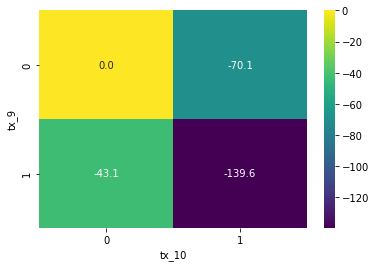

In [125]:
pdp_df = pd.DataFrame(partial_dependence_values)
pdp_df = pdp_df.sort_values(by = "tx_9", ascending = True)
ht_data = pdp_df.pivot(index = "tx_9", columns = "tx_10", values = "pred")

sns.heatmap(ht_data, annot = True, cmap = "viridis", fmt=".1f")